In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import json
from PIL import Image

# Ruta a la carpeta donde están todos los archivos
RUTA = "/content/drive/MyDrive/5 semestre/Big data/Trabajo final/Dataset"

# Diccionario de clases
clases = {
    "Blue_visible": "blue_visible",
    "Blue_occluded": "blue_occluded",
    "Unblue_visible": "unblue_visible",
    "Unblue_occluded": "unblue_occluded"
}

# Crear carpeta de salida
DESTINO = os.path.join(RUTA, "recortes")
os.makedirs(DESTINO, exist_ok=True)
for clase in clases.values():
    os.makedirs(os.path.join(DESTINO, clase), exist_ok=True)

# Buscar todos los archivos .json en la carpeta
archivos_json = [f for f in os.listdir(RUTA) if f.endswith(".json")]

# Procesar cada archivo
contador = 0
for archivo_json in archivos_json:
    ruta_json = os.path.join(RUTA, archivo_json)

    with open(ruta_json) as f:
        data = json.load(f)

    # Nombre base del archivo (sin extensión)
    base = archivo_json.replace(".json", "")
    ruta_img = os.path.join(RUTA, base + ".jpg")

    if not os.path.exists(ruta_img):
        print(f"⚠️ Imagen no encontrada: {ruta_img}")
        continue

    img = Image.open(ruta_img)
    key = list(data.keys())[0]  # nombre de la clave del diccionario (imagen)

    regiones = data[key]["regions"]
    for i, (shape, attr) in enumerate(zip(regiones["shape_attributes"], regiones["region_attributes"])):
        x, y, w, h = shape["x"], shape["y"], shape["width"], shape["height"]
        crop = img.crop((x, y, x + w, y + h))

        blueberry_attr = attr["Blueberry"]
        for k in blueberry_attr:
            if blueberry_attr[k]:
                clase = clases.get(k, "otros")
                nombre = f"{base}_crop_{contador:04d}.jpg"
                crop.save(os.path.join(DESTINO, clase, nombre))
                contador += 1
                break

print(f"✅ Recorte y clasificación completados. Total recortes: {contador}")


✅ Recorte y clasificación completados. Total recortes: 17854


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread

In [ ]:
# Instalar dependencias
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
!pip install split-folders
import splitfolders

# Ruta de tu carpeta "recortes" con las 4 subcarpetas originales
input_dir = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final/Dataset/recortes'

# Ruta de salida para train/validation
output_dir = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final'

splitfolders.ratio(
    input_dir,
    output=output_dir,
    seed=42,
    ratio=(0.8, 0.2),  # Proporción train/validation
    group_prefix=None
)

ValueError: The provided input folder "/content/drive/MyDrive/5 semestre/Big data/Trabajo final/Dataset/recortes" does not exists.

In [ ]:
# Rutas a tus datos
train_dir = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final/train'
val_dir = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final/val'

# Generadores de datos con aumento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'  # ¡Cambiado aquí!
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'  # ¡Cambiado aquí!
)

Found 14281 images belonging to 4 classes.
Found 3573 images belonging to 4 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 clases de salida
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # ¡Cambiado aquí!
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print("Clases detectadas en entrenamiento:", train_generator.class_indices)
print("Clases detectadas en validación:", validation_generator.class_indices)

Clases detectadas en entrenamiento: {'blue_occluded': 0, 'blue_visible': 1, 'unblue_occluded': 2, 'unblue_visible': 3}
Clases detectadas en validación: {'blue_occluded': 0, 'blue_visible': 1, 'unblue_occluded': 2, 'unblue_visible': 3}


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 4013s 9s/step - accuracy: 0.5374 - loss: 1.0418 - val_accuracy: 0.6301 - val_loss: 0.8189
Epoch 2/30
  1/446 ━━━━━━━━━━━━━━━━━━━━ 17:41 2s/step - accuracy: 0.5938 - loss: 0.9923

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


446/446 ━━━━━━━━━━━━━━━━━━━━ 66s 143ms/step - accuracy: 0.5938 - loss: 0.9923 - val_accuracy: 0.6320 - val_loss: 0.8202
Epoch 3/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.6185 - loss: 0.8386 - val_accuracy: 0.6450 - val_loss: 0.7767
Epoch 4/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 82s 181ms/step - accuracy: 0.6250 - loss: 0.7779 - val_accuracy: 0.6425 - val_loss: 0.7953
Epoch 5/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.6256 - loss: 0.8165 - val_accuracy: 0.6374 - val_loss: 0.7775
Epoch 6/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 84s 185ms/step - accuracy: 0.6250 - loss: 0.7440 - val_accuracy: 0.6441 - val_loss: 0.7607
Epoch 7/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 979s 2s/step - accuracy: 0.6278 - loss: 0.8017 - val_accuracy: 0.6636 - val_loss: 0.7308
Epoch 8/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.7188 - loss: 0.6499 - val_accuracy: 0.6675 - val_loss: 0.7254
Epoch 9/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.6457 - loss: 0.7822 - val_accurac

In [ ]:
model.save('/content/drive/MyDrive/5 semestre/Big data/Trabajo final/fruit_maturity_model.h5')

NameError: name 'model' is not defined

PRUEBA DE CODIGO PARA CLASIFICACION

In [ ]:
import os
from tensorflow.keras.models import save_model

# =============================================
# 1. Definir rutas (¡personaliza estos valores!)
# =============================================
# Ruta base de Google Drive
drive_path = "/content/drive/MyDrive"

# Ruta específica para guardar el modelo
carpeta_destino = os.path.join(
    drive_path,
    "5 semestre",  # ¡Las carpetas con espacios son válidas!
    "Big data",
    "Trabajo final"
)

# Nombre del archivo (sin extensión)
nombre_modelo = "modelo_frutos_maduracion"

# =============================================
# 2. Crear directorio si no existe
# =============================================
os.makedirs(carpeta_destino, exist_ok=True)

# =============================================
# 3. Guardar modelo en formato .keras
# =============================================
# Ruta completa del modelo
ruta_completa = os.path.join(carpeta_destino, f"{nombre_modelo}.keras")

# Guardar el modelo
save_model(model, ruta_completa)

# =============================================
# 4. Confirmación
# =============================================
print(f"\n✅ Modelo guardado en:\n{ruta_completa}")
print(f"Tamaño del archivo: {os.path.getsize(ruta_completa)/1024/1024:.2f} MB")

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

ruta_cargado = os.path.join(
    "/content/drive/MyDrive/5 semestre/Big data/Trabajo final",
    "modelo_frutos_maduracion.keras"
)

model = load_model(ruta_cargado)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
import numpy as np

# Cargar el modelo desde Drive
model_path = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final/modelo_frutos_maduracion.keras'  # Ajusta la ruta
model = load_model(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar el generador de datos de validación (asegúrate de que los datos estén en la misma estructura que durante el entrenamiento)
val_dir = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final/val'  # Ruta de la carpeta de validación

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),  # Mismo tamaño que durante el entrenamiento
    batch_size=32,
    class_mode='sparse',  # Debe coincidir con la configuración del entrenamiento
    shuffle=False  # Importante para que las etiquetas coincidan con las predicciones
)

Found 3573 images belonging to 4 classes.


In [ ]:
# Reiniciar el generador y obtener predicciones
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener etiquetas reales
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 683s 6s/step


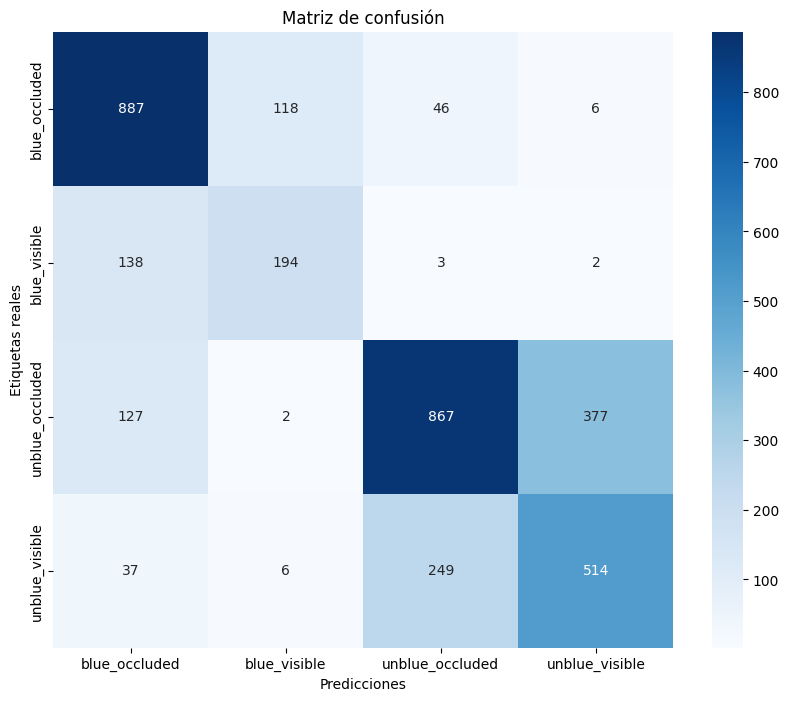

                 precision    recall  f1-score   support

  blue_occluded       0.75      0.84      0.79      1057
   blue_visible       0.61      0.58      0.59       337
unblue_occluded       0.74      0.63      0.68      1373
 unblue_visible       0.57      0.64      0.60       806

       accuracy                           0.69      3573
      macro avg       0.67      0.67      0.67      3573
   weighted avg       0.69      0.69      0.69      3573


Precisión total del modelo: 68.91%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas reales")
plt.title("Matriz de confusión")
plt.show()

# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Precisión total
accuracy = np.mean(predicted_classes == true_classes)
print(f"\nPrecisión total del modelo: {accuracy * 100:.2f}%")

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_fruits(img_path):
    # Cargar imagen
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convertir a espacio HSV para segmentación por color
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Definir rangos de color para los frutos (ajusta según tus datos)
    lower_blue = np.array([90, 50, 50])    # Tonos azules/morados
    upper_blue = np.array([130, 255, 255])

    # Máscara para aislar frutos
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Operaciones morfológicas para limpiar la máscara
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Encontrar contornos
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar contornos pequeños (ajusta min_area)
    min_area = 500  # Área mínima en píxeles para considerar un fruto
    rois = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            rois.append((x, y, w, h))

    return img_rgb, rois

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Cargar modelo
model = load_model('/content/drive/MyDrive/5 semestre/Big data/Trabajo final/modelo_frutos_maduracion.keras')

def classify_rois(img_path, target_size=(150,150)):
    # Detectar ROIs
    img, rois = detect_fruits(img_path)

    # Clasificar cada ROI
    results = []
    for (x, y, w, h) in rois:
        # Recortar ROI
        roi = img[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, target_size)

        # Preprocesar para el modelo
        roi_array = image.img_to_array(roi_resized) / 255.0
        roi_array = np.expand_dims(roi_array, axis=0)

        # Predecir clase
        pred = model.predict(roi_array)
        class_idx = np.argmax(pred)
        confidence = np.max(pred) * 100

        # Mapear índice a nombre de clase
        class_names = ['blue_occluded', 'blue_visible', 'unblue_occluded', 'unblue_visible']
        class_label = class_names[class_idx]

        results.append({
            "box": (x, y, w, h),
            "class": class_label,
            "confidence": confidence
        })

    return img, results

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def plot_predictions(img_path):
    img, results = classify_rois(img_path)
    plt.figure(figsize=(10,10))
    plt.imshow(img)

    for result in results:
        x, y, w, h = result["box"]
        class_label = result["class"]
        confidence = result["confidence"]

        # Dibujar rectángulo y texto
        rect = plt.Rectangle((x,y), w, h, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x, y-10, f"{class_label} ({confidence:.1f}%)",
                 color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


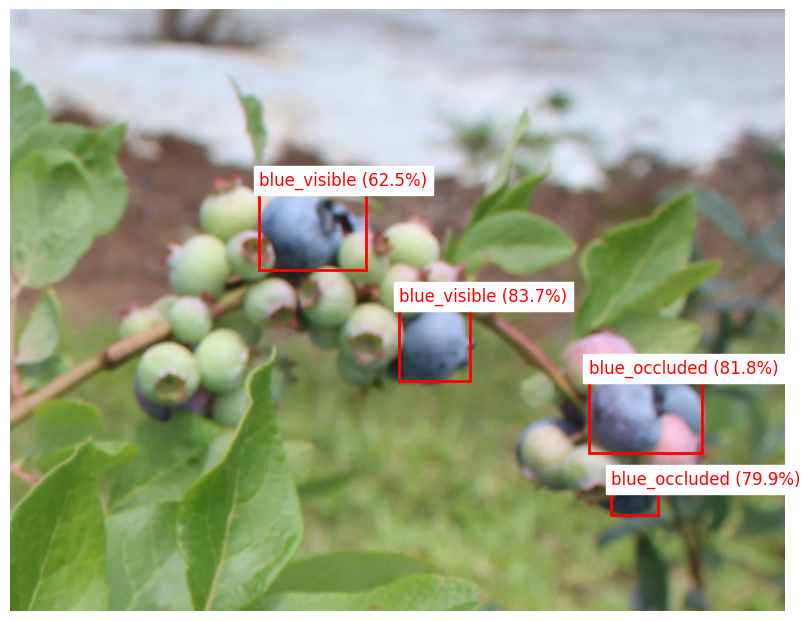

In [ ]:
# Ruta de la imagen con múltiples frutos
img_path = '/content/drive/MyDrive/5 semestre/Big data/Trabajo final/Dataset/MSState_YL_Cropped_0001.jpg'

# Clasificar y mostrar
plot_predictions(img_path)